# Train a multi-layer perceptron (MLP) classification model using PyTorch

We use the Fashion MNIST data to train and test this MLP classification model.

In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

## Load and process Fashion MNIST data for image classification

Fashion MNIST contains 70,000 28x28 images (60,000 for training and 10,000 for testing), and each image has 784 pixel values (784-dimensional features) 

In [4]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the Fashion MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Plot some Fashion MNIST examples

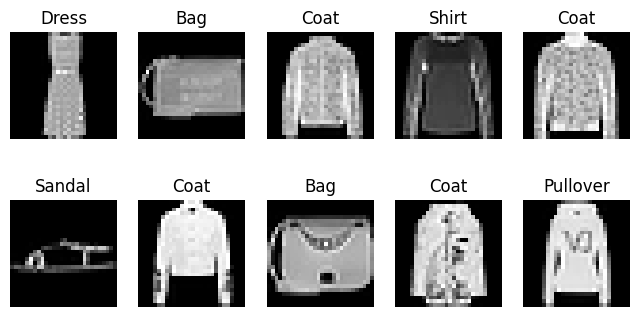

In [5]:
#One batach has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

## Construct a multi-layer perceptron (MLP) for image classification

In [6]:
np.random.seed(42)
torch.manual_seed(42)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()    #Convert the image from matrix to vector
        self.fc1 = nn.Linear(784, 300) #The input layer with 784 features, and the first hidden layer with 300 neurons
        self.fc2 = nn.Linear(300, 100) #The second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 10)  #The output layer with 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))        #The first hidden layer uses ReLU activation function
        x = F.relu(self.fc2(x))        #The first hidden layer uses ReLU activation function
        x = self.fc3(x)                #The output layer does not apply any activation function here, but will be processed directly by loss function
        return x

## Set up some hyperparameters: use cross entropy loss, gradient descent with Adam optimizer, learning rate, and epochs

In [7]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()   #Cross entropy loss for multi-class classification

#Instantiate the model from "MultiClassification" class definition
model = MLP()

#Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


## Train the model using train_dataloader

In [8]:
#Define the training function
def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))
    
    
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch, model, train_dataloader, optimizer, lossfunction)

epoch (1): Train accuracy: 0.7972, loss: 0.009
epoch (2): Train accuracy: 0.8304, loss: 0.007
epoch (3): Train accuracy: 0.8387, loss: 0.007
epoch (4): Train accuracy: 0.8383, loss: 0.007
epoch (5): Train accuracy: 0.8404, loss: 0.007
epoch (6): Train accuracy: 0.8409, loss: 0.007
epoch (7): Train accuracy: 0.8412, loss: 0.007
epoch (8): Train accuracy: 0.8430, loss: 0.007
epoch (9): Train accuracy: 0.8442, loss: 0.007
epoch (10): Train accuracy: 0.8451, loss: 0.007


## Test the model using test_dataloader

In [12]:
#Define the test function
def test():
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
            _, test_predicted = torch.max(predictions.data, 1)
        
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    f1 = f1_score(y_test, y_pred, average="macro")
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, f1))
    
    return y_test, y_pred

#Test the model
y_test, y_pred = test()

Test accuracy: 0.8318, macro f1_score: 0.8268


## Output the confusion matrix

In [13]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[879   8  16  27   0   1  56   0  13   0]
 [  3 967   2  25   1   0   0   0   2   0]
 [ 13   8 855  15  67   0  32   0  10   0]
 [ 43  18  13 882  19   0  18   0   7   0]
 [  1   7 299  63 552   0  71   0   7   0]
 [  1   1   0   0   0 881   0  90   3  24]
 [238  12 189  23  47   1 470   0  20   0]
 [  0   0   0   0   0   8   0 980   0  12]
 [  1   1  12   5   2   4  13  10 952   0]
 [  0   2   0   0   0  10   0  87   1 900]]


## Calculate accuracy, macro F1-score, and micro F1-score

In [14]:
acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')
print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

Accuracy: 0.83
Macro F1-score: 0.83
Micro F1-score: 0.83
